In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Version PyTorch uses:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Capability Score:", torch.cuda.get_device_capability(0))
else:
    print("No GPU detected!")

/home/anany.sharma/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


PyTorch Version: 2.6.0+cu124
CUDA Version PyTorch uses: 12.4
GPU Name: NVIDIA L4
GPU Capability Score: (8, 9)


Running Inference on: cuda
Models Loaded: ['SimpleConv', 'DeeperConv', 'GAN', 'Fast-DDPM']
>>> Generating 5 Examples...


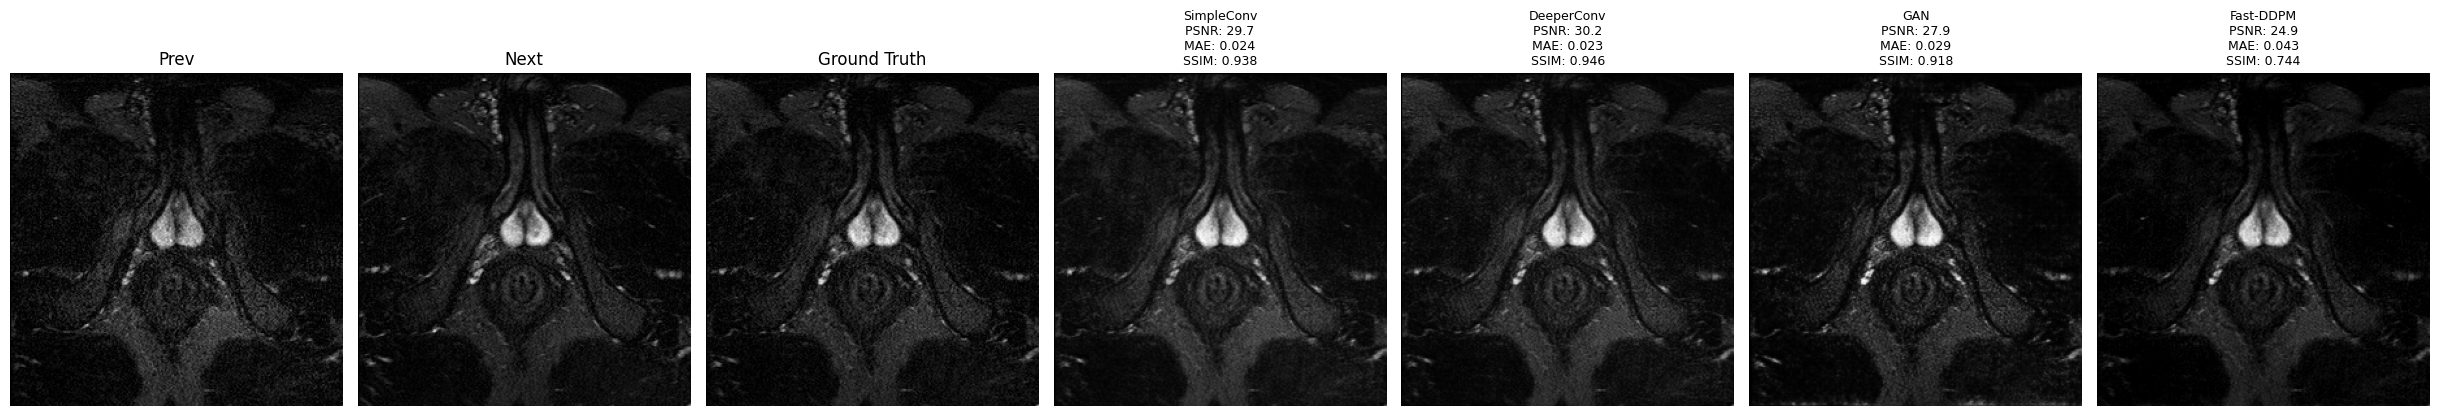

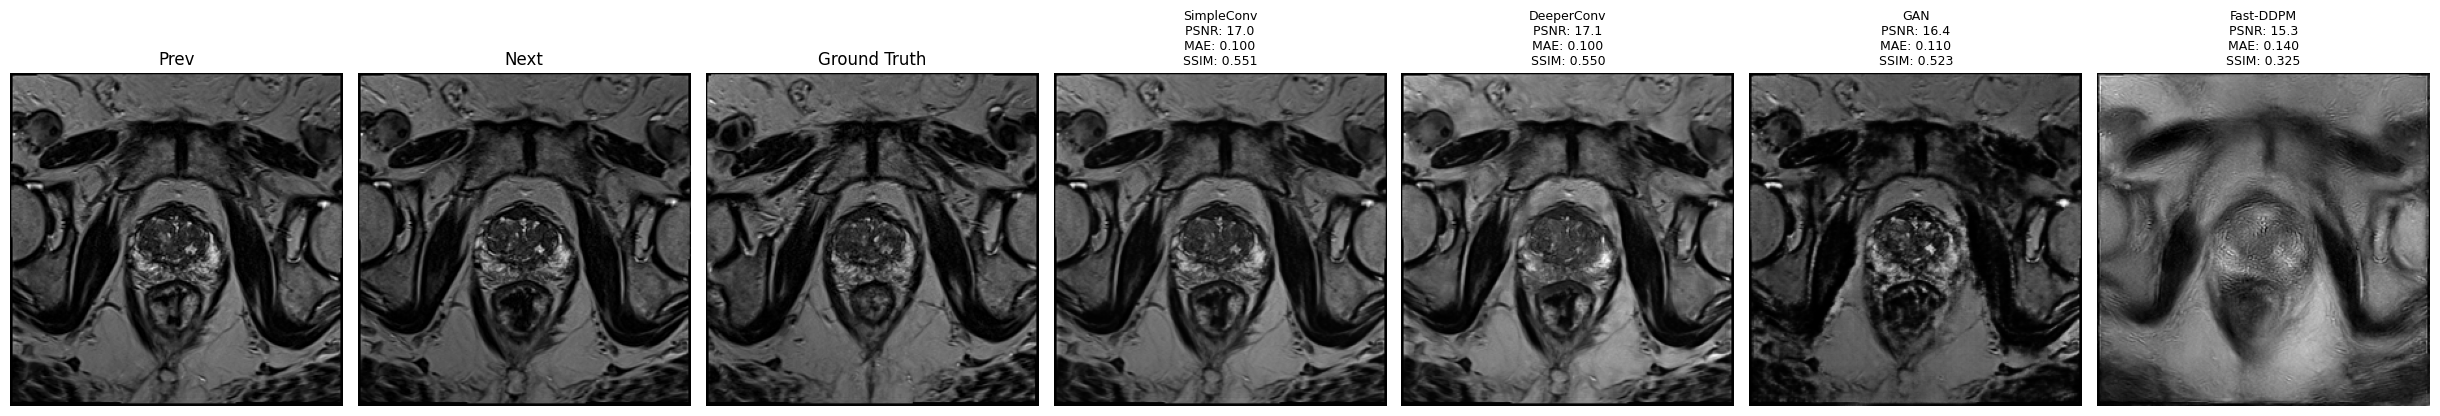

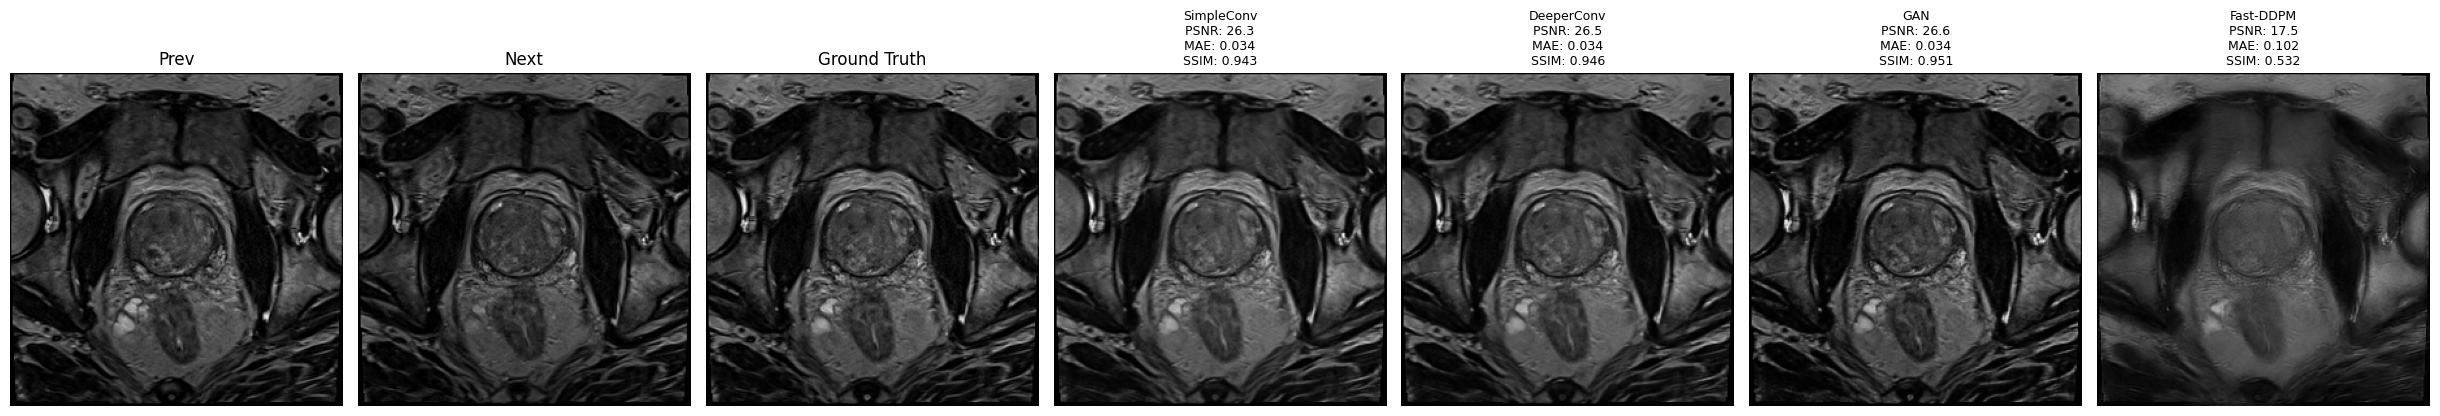

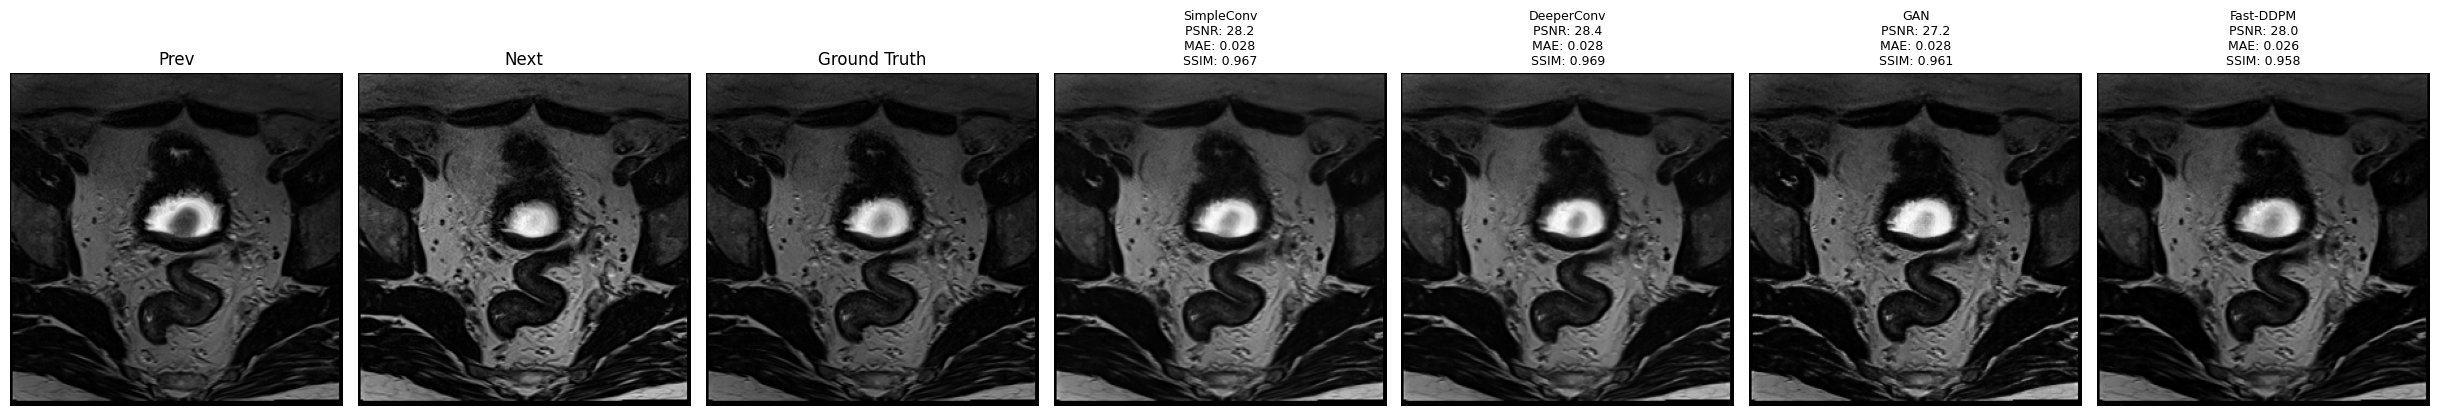

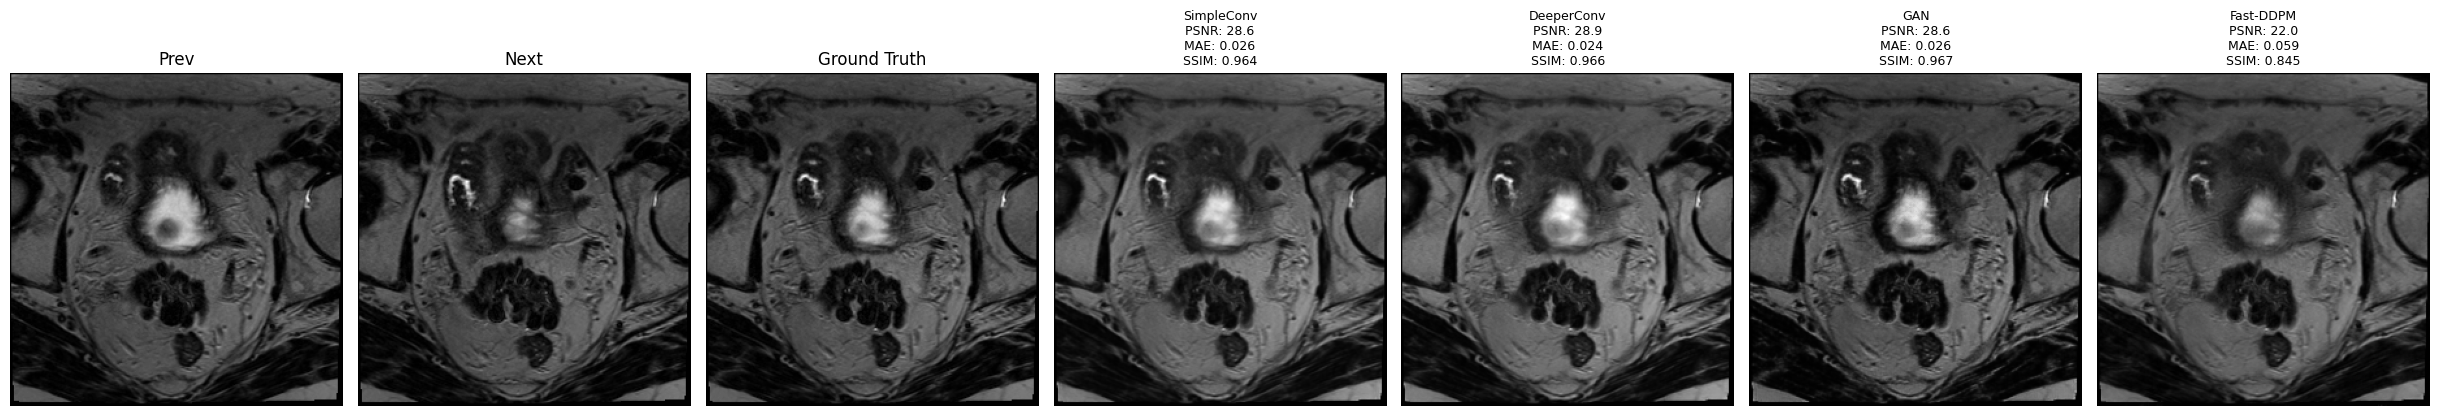

Running Stats (100 samples)...


  0%|          | 0/100 [00:00<?, ?it/s]

/scratch/local/20249727/ipykernel_2075359/1723589761.py:367: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(stats_psnr.keys()); axes[0].set_title("PSNR (Higher is better)"); axes[0].set_ylabel("dB")
/scratch/local/20249727/ipykernel_2075359/1723589761.py:370: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(stats_mae.keys()); axes[1].set_title("MAE (Lower is better)"); axes[1].set_ylabel("L1 Error")
/scratch/local/20249727/ipykernel_2075359/1723589761.py:373: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(stats_ssim.keys()); axes[2].set_title("SSIM (Higher is better)"); axes[2].set_ylabel("Index")


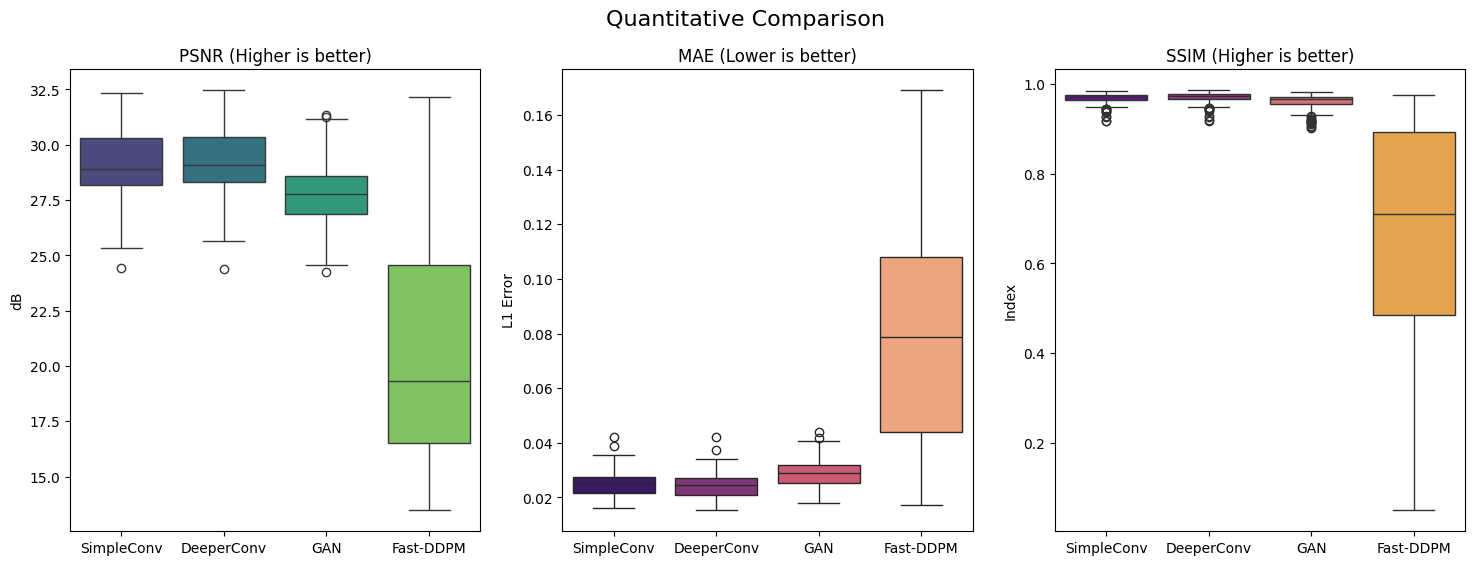

In [6]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm

# ============================================================
# 1. SETUP & CONFIGURATION
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DATA_PATH = Path("ProstateMRI_T2_MR_png/test/HR")

# Updated Filenames based on the Refactored Training Script
CHECKPOINTS = {
    "SimpleConv": "best_SimpleConvolutionalModel.pth",
    "DeeperConv": "best_DeeperConvolutionalModel.pth",
    "GAN": "best_SliceSynthesizer_G.pth",
    "Fast-DDPM": "mri_interp_weights.pth" 
}

print(f"Running Inference on: {DEVICE}")

# ============================================================
# 2. METRIC FUNCTIONS
# ============================================================

def calc_psnr(a, b):
    mse = F.mse_loss(a, b).item()
    return 20 * math.log10(1.0/math.sqrt(mse)) if mse > 0 else 100

def calc_mae(a, b):
    return F.l1_loss(a, b).item()

def calc_ssim(img1, img2):
    if img1.dim() == 4: img1 = img1.squeeze()
    if img2.dim() == 4: img2 = img2.squeeze()
    mu1, mu2 = img1.mean(), img2.mean()
    var1, var2 = img1.var(), img2.var()
    cov = ((img1 - mu1) * (img2 - mu2)).mean()
    c1, c2 = 0.0001, 0.0009
    return ((2 * mu1 * mu2 + c1) * (2 * cov + c2) / ((mu1**2 + mu2**2 + c1) * (var1 + var2 + c2))).item()

# ============================================================
# 3. REFACTORED MODEL ARCHITECTURES
# ============================================================

# --- 1. Simple Convolutional Model (Was SRCNN) ---
class SimpleConvolutionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Conv2d(2, 64, 9, padding=4)
        self.non_linear_map = nn.Conv2d(64, 32, 5, padding=2)
        self.reconstruction = nn.Conv2d(32, 1, 5, padding=2)

    def forward(self, x):
        x = F.relu(self.feature_extractor(x))
        x = F.relu(self.non_linear_map(x))
        return torch.sigmoid(self.reconstruction(x))

# --- 2. Deeper Convolutional Model (Was DeepSRCNN) ---
class DeeperConvolutionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        layer_list = []
        input_channels = 2
        for output_channels in [64, 64, 64, 32]:
            layer_list.append(nn.Conv2d(input_channels, output_channels, 3, padding=1))
            layer_list.append(nn.ReLU(inplace=True))
            input_channels = output_channels
        layer_list.append(nn.Conv2d(input_channels, 1, 3, padding=1))
        self.network = nn.Sequential(*layer_list)

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# --- 3. Slice Synthesizer (GAN Generator) ---
class UNetConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels, is_downsample=True):
        super().__init__()
        if is_downsample:
            self.operation = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, 4, 2, 1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, True),
            )
        else:
            self.operation = nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, 4, 2, 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(True),
            )
    def forward(self, x): return self.operation(x)

class SliceSynthesizer(nn.Module):
    def __init__(self, base_filters=64):
        super().__init__()
        self.down_a = UNetConvBlock(2, base_filters, True)
        self.down_b = UNetConvBlock(base_filters, base_filters * 2, True)
        self.down_c = UNetConvBlock(base_filters * 2, base_filters * 4, True)
        self.deepest_point = nn.Sequential(
            nn.Conv2d(base_filters * 4, base_filters * 4, 3, 1, 1), 
            nn.ReLU(True)
        )
        self.up_c = UNetConvBlock(base_filters * 4, base_filters * 2, False)
        self.up_b = UNetConvBlock(base_filters * 4, base_filters, False)
        self.up_a = UNetConvBlock(base_filters * 2, base_filters, False)
        self.output_layer = nn.Conv2d(base_filters, 1, 3, padding=1)

    def forward(self, x):
        d_a = self.down_a(x)
        d_b = self.down_b(d_a)
        d_c = self.down_c(d_b)
        b = self.deepest_point(d_c)
        u_c = self.up_c(b); u_c = torch.cat([u_c, d_b], dim=1)
        u_b = self.up_b(u_c); u_b = torch.cat([u_b, d_a], dim=1)
        u_a = self.up_a(u_b)
        return torch.sigmoid(self.output_layer(u_a))

# --- 4. Fast-DDPM (ConditionalResUNet) ---
def make_time_embed(steps, dim_out, dev):
    half_d = dim_out // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half_d, device=dev).float() / half_d)
    raw = steps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(raw), torch.cos(raw)], dim=-1)
    if dim_out % 2 == 1: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb

class TimeAwareResBlock(nn.Module):
    def __init__(self, ch_in, ch_out, t_dim):
        super().__init__()
        self.c1 = nn.Conv2d(ch_in, ch_out, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, ch_out)
        self.c2 = nn.Conv2d(ch_out, ch_out, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, ch_out)
        self.t_proj = nn.Linear(t_dim, ch_out)
        self.activ = nn.SiLU()
        self.bypass = nn.Conv2d(ch_in, ch_out, 1) if ch_in != ch_out else nn.Identity()
    def forward(self, x, t_vec):
        h = self.activ(self.gn1(self.c1(x)))
        h = h + self.t_proj(t_vec)[:, :, None, None]
        h = self.activ(self.gn2(self.c2(h)))
        return h + self.bypass(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, t_dim, shrink=True):
        super().__init__()
        self.b1 = TimeAwareResBlock(in_c, out_c, t_dim)
        self.b2 = TimeAwareResBlock(out_c, out_c, t_dim)
        self.sampler = nn.Conv2d(out_c, out_c, 4, 2, 1) if shrink else nn.Identity()
    def forward(self, x, t):
        x = self.b1(x, t); x = self.b2(x, t)
        return self.sampler(x), x

class DecoderBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c, t_dim, grow=True):
        super().__init__()
        self.sampler = nn.ConvTranspose2d(in_c, out_c, 4, 2, 1) if grow else nn.Identity()
        self.b1 = TimeAwareResBlock(out_c + skip_c, out_c, t_dim)
        self.b2 = TimeAwareResBlock(out_c, out_c, t_dim)
    def forward(self, x, skip, t):
        x = self.sampler(x); x = torch.cat([x, skip], dim=1)
        x = self.b1(x, t); x = self.b2(x, t)
        return x

class ConditionalResUNet(nn.Module):
    def __init__(self, t_dim=256, dim=64):
        super().__init__()
        self.t_dim = t_dim
        self.time_net = nn.Sequential(nn.Linear(t_dim, t_dim), nn.SiLU(), nn.Linear(t_dim, t_dim))
        self.e1 = EncoderBlock(3, dim, t_dim)
        self.e2 = EncoderBlock(dim, dim * 2, t_dim)
        self.e3 = EncoderBlock(dim * 2, dim * 4, t_dim)
        self.mid1 = TimeAwareResBlock(dim * 4, dim * 4, t_dim)
        self.mid2 = TimeAwareResBlock(dim * 4, dim * 4, t_dim)
        self.d3 = DecoderBlock(dim * 4, dim * 4, dim * 2, t_dim)
        self.d2 = DecoderBlock(dim * 2, dim * 2, dim, t_dim)
        self.final_up = nn.ConvTranspose2d(dim, dim, 4, 2, 1)
        self.head = nn.Sequential(nn.Conv2d(dim, dim, 3, padding=1), nn.SiLU(), nn.Conv2d(dim, 1, 3, padding=1))

    def forward(self, noisy_img, context_imgs, t_step):
        emb = self.time_net(make_time_embed(t_step, self.t_dim, noisy_img.device))
        combined = torch.cat([noisy_img, context_imgs], dim=1)
        x, s1 = self.e1(combined, emb); x, s2 = self.e2(x, emb); x, s3 = self.e3(x, emb)
        x = self.mid2(self.mid1(x, emb), emb)
        x = self.d3(x, s3, emb); x = self.d2(x, s2, emb)
        return self.head(self.final_up(x))

class FastDDPMSampler:
    def __init__(self, device):
        self.device = device
        self.T_base, self.T_fast = 1000, 10
        boundary = 699
        n_high = int(self.T_fast * 0.6); n_low = self.T_fast - n_high
        low = torch.linspace(0, boundary, n_low, device=device)
        high = torch.linspace(boundary, self.T_base - 1, n_high, device=device)
        self.fast_indices = torch.cat([low, high]).round().long().sort()[0]
        betas = torch.linspace(1e-4, 2e-2, self.T_base, device=device)
        alphas_cumprod = torch.cumprod(1.0 - betas, dim=0)
        self.alphas_cumprod_fast = alphas_cumprod[self.fast_indices]
        self.alphas_fast = torch.empty_like(self.alphas_cumprod_fast)
        self.alphas_fast[0] = self.alphas_cumprod_fast[0]
        self.alphas_fast[1:] = self.alphas_cumprod_fast[1:] / self.alphas_cumprod_fast[:-1]
        self.betas_fast = 1.0 - self.alphas_fast
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas_fast)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod_fast)
        self.posterior_variance = self.betas_fast * (1.0 - torch.cat([torch.tensor([1.0], device=device), self.alphas_cumprod_fast[:-1]])) / (1.0 - self.alphas_cumprod_fast)

    def sample(self, model, ctx):
        model.eval()
        b, _, h, w = ctx.shape
        x = torch.randn(b, 1, h, w, device=self.device)
        for i in reversed(range(self.T_fast)):
            t = torch.full((b,), i, device=self.device, dtype=torch.long)
            with torch.no_grad(): eps = model(x, ctx, t)
            mean = self.sqrt_recip_alphas[i] * (x - self.betas_fast[i] / self.sqrt_one_minus_alphas_cumprod[i] * eps)
            noise = torch.randn_like(x) if i > 0 else 0
            x = mean + torch.sqrt(self.posterior_variance[i]) * noise
        return x.clamp(0, 1)

# ============================================================
# 4. ROBUST DATA LOADING
# ============================================================
def get_test_triplets(root_dir):
    if not root_dir.exists():
        print(f"ERROR: Path {root_dir} does not exist.")
        return []
        
    files = sorted(list(root_dir.glob("*.png")))
    patient_files = {}
    for f in files:
        parts = f.stem.split('_z')
        if len(parts) != 2: continue
        pid, idx = parts[0], int(parts[1])
        if pid not in patient_files: patient_files[pid] = []
        patient_files[pid].append((idx, f))
    
    triplets = []
    for pid, slices in patient_files.items():
        slices.sort(key=lambda x: x[0])
        for i in range(1, len(slices)-1):
            if slices[i][0] == slices[i-1][0] + 1 and slices[i+1][0] == slices[i][0] + 1:
                triplets.append((slices[i-1][1], slices[i][1], slices[i+1][1]))
    return triplets

def load_image(path):
    try:
        img = Image.open(path).convert("F").resize((256, 256))
        return torch.from_numpy(np.array(img)/255.0).unsqueeze(0).unsqueeze(0).float()
    except (OSError, UnidentifiedImageError):
        print(f"Skipping corrupt image: {path.name}")
        return None

# ============================================================
# 5. EXECUTION
# ============================================================
sampler = FastDDPMSampler(DEVICE)
models = {}

def load_ckpt(model, path):
    try:
        state = torch.load(path, map_location=DEVICE)
        # Handle DataParallel Wrapping
        if list(state.keys())[0].startswith('module.'):
            state = {k[7:]: v for k, v in state.items()}
        model.load_state_dict(state)
        return model.eval().to(DEVICE)
    except Exception as e:
        print(f"FAILED {path}: {e}")
        return None

# Load models using new class names
if os.path.exists(CHECKPOINTS["SimpleConv"]): 
    models["SimpleConv"] = load_ckpt(SimpleConvolutionalModel(), CHECKPOINTS["SimpleConv"])

if os.path.exists(CHECKPOINTS["DeeperConv"]): 
    models["DeeperConv"] = load_ckpt(DeeperConvolutionalModel(), CHECKPOINTS["DeeperConv"])

if os.path.exists(CHECKPOINTS["GAN"]): 
    models["GAN"] = load_ckpt(SliceSynthesizer(), CHECKPOINTS["GAN"])

if os.path.exists(CHECKPOINTS["Fast-DDPM"]): 
    models["Fast-DDPM"] = load_ckpt(ConditionalResUNet(), CHECKPOINTS["Fast-DDPM"])

print(f"Models Loaded: {list(models.keys())}")

# --- 1. Qualitative (5 Examples) ---
print(">>> Generating 5 Examples...")
triplets = get_test_triplets(TEST_DATA_PATH)
if len(triplets) > 0:
    step = max(1, len(triplets) // 5)
    indices = [i * step for i in range(5)]

    for count, idx in enumerate(indices):
        if idx >= len(triplets): break
        
        p_path, m_path, n_path = triplets[idx]
        prev = load_image(p_path)
        nxt  = load_image(n_path)
        gt   = load_image(m_path)
        
        if prev is None or nxt is None or gt is None: continue
            
        prev, nxt, gt = prev.to(DEVICE), nxt.to(DEVICE), gt.to(DEVICE)
        ctx = torch.cat([prev, nxt], 1)
        
        outputs = {}
        with torch.no_grad():
            for name, model in models.items():
                if name == "Fast-DDPM": outputs[name] = sampler.sample(model, ctx)
                else: outputs[name] = model(ctx).clamp(0, 1)

        n_cols = 3 + len(outputs)
        fig, axes = plt.subplots(1, n_cols, figsize=(3.5*n_cols, 4.5))
        axes[0].imshow(prev.cpu().squeeze(), cmap="gray"); axes[0].set_title("Prev")
        axes[1].imshow(nxt.cpu().squeeze(), cmap="gray"); axes[1].set_title("Next")
        axes[2].imshow(gt.cpu().squeeze(), cmap="gray"); axes[2].set_title("Ground Truth")
        
        for i, (name, img) in enumerate(outputs.items()):
            p_val = calc_psnr(img, gt)
            m_val = calc_mae(img, gt)
            s_val = calc_ssim(img, gt)
            axes[3+i].imshow(img.cpu().squeeze(), cmap="gray")
            axes[3+i].set_title(f"{name}\nPSNR: {p_val:.1f}\nMAE: {m_val:.3f}\nSSIM: {s_val:.3f}", fontsize=9)
            
        for ax in axes: ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"Final_Report_Qualitative_{count+1}.png", dpi=300)
        plt.show()

# --- 2. Quantitative (Boxplots) ---
print("Running Stats (100 samples)...")
stats_psnr = {k: [] for k in models.keys()}
stats_mae  = {k: [] for k in models.keys()}
stats_ssim = {k: [] for k in models.keys()}



for p, m, n in tqdm(triplets[:100]):
    prev = load_image(p)
    nxt  = load_image(n)
    gt   = load_image(m)
    
    if prev is None or nxt is None or gt is None: continue
    
    prev, nxt, gt = prev.to(DEVICE), nxt.to(DEVICE), gt.to(DEVICE)
    ctx = torch.cat([prev, nxt], 1)
    
    with torch.no_grad():
        for name, model in models.items():
            if name == "Fast-DDPM": pred = sampler.sample(model, ctx)
            else: pred = model(ctx).clamp(0, 1)
            
            stats_psnr[name].append(calc_psnr(pred, gt))
            stats_mae[name].append(calc_mae(pred, gt))
            stats_ssim[name].append(calc_ssim(pred, gt))

if len(list(stats_psnr.values())[0]) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.boxplot(data=list(stats_psnr.values()), ax=axes[0], palette="viridis")
    axes[0].set_xticklabels(stats_psnr.keys()); axes[0].set_title("PSNR (Higher is better)"); axes[0].set_ylabel("dB")

    sns.boxplot(data=list(stats_mae.values()), ax=axes[1], palette="magma")
    axes[1].set_xticklabels(stats_mae.keys()); axes[1].set_title("MAE (Lower is better)"); axes[1].set_ylabel("L1 Error")

    sns.boxplot(data=list(stats_ssim.values()), ax=axes[2], palette="plasma")
    axes[2].set_xticklabels(stats_ssim.keys()); axes[2].set_title("SSIM (Higher is better)"); axes[2].set_ylabel("Index")

    plt.suptitle("Quantitative Comparison", fontsize=16)
    plt.savefig("Final_Report_All_Stats.png", dpi=300)
    plt.show()

Running Inference on: cuda
Models Loaded: ['SimpleConv', 'DeeperConv', 'GAN', 'Fast-DDPM']
>>> Generating 5 Examples...


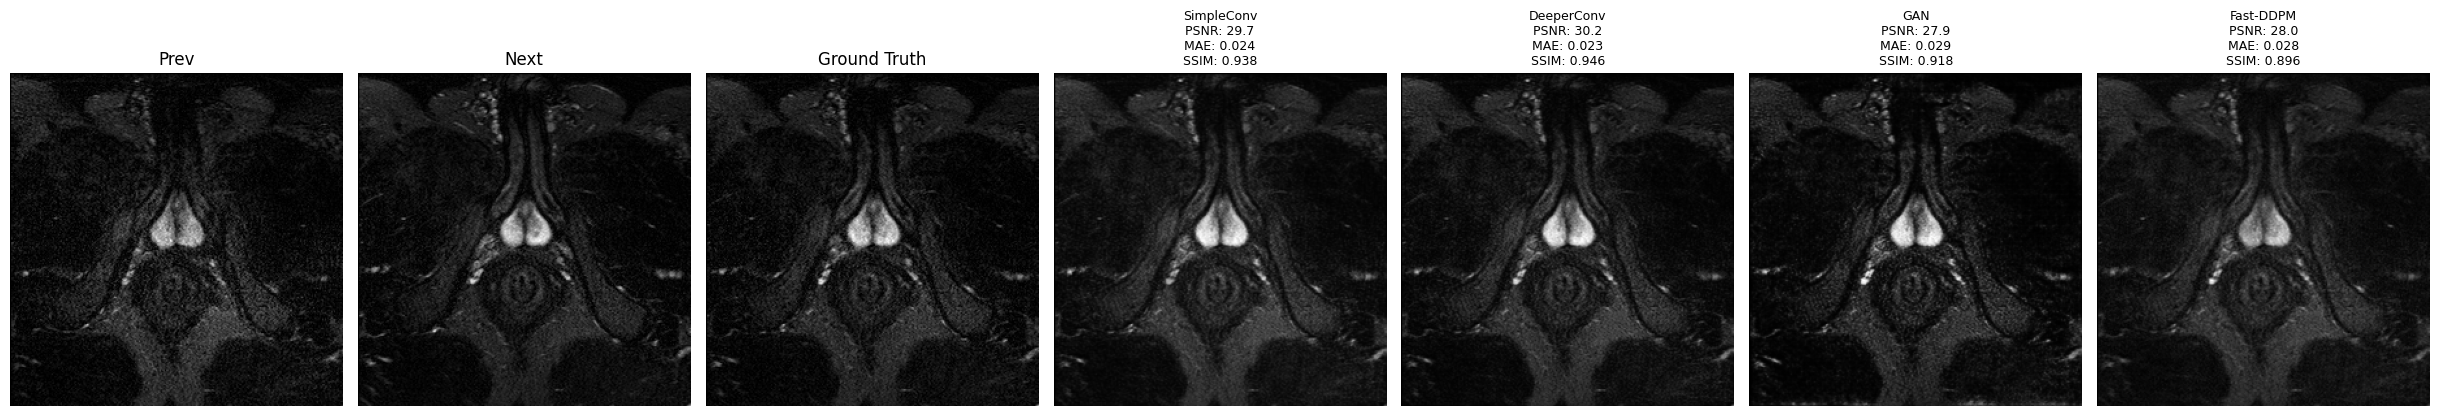

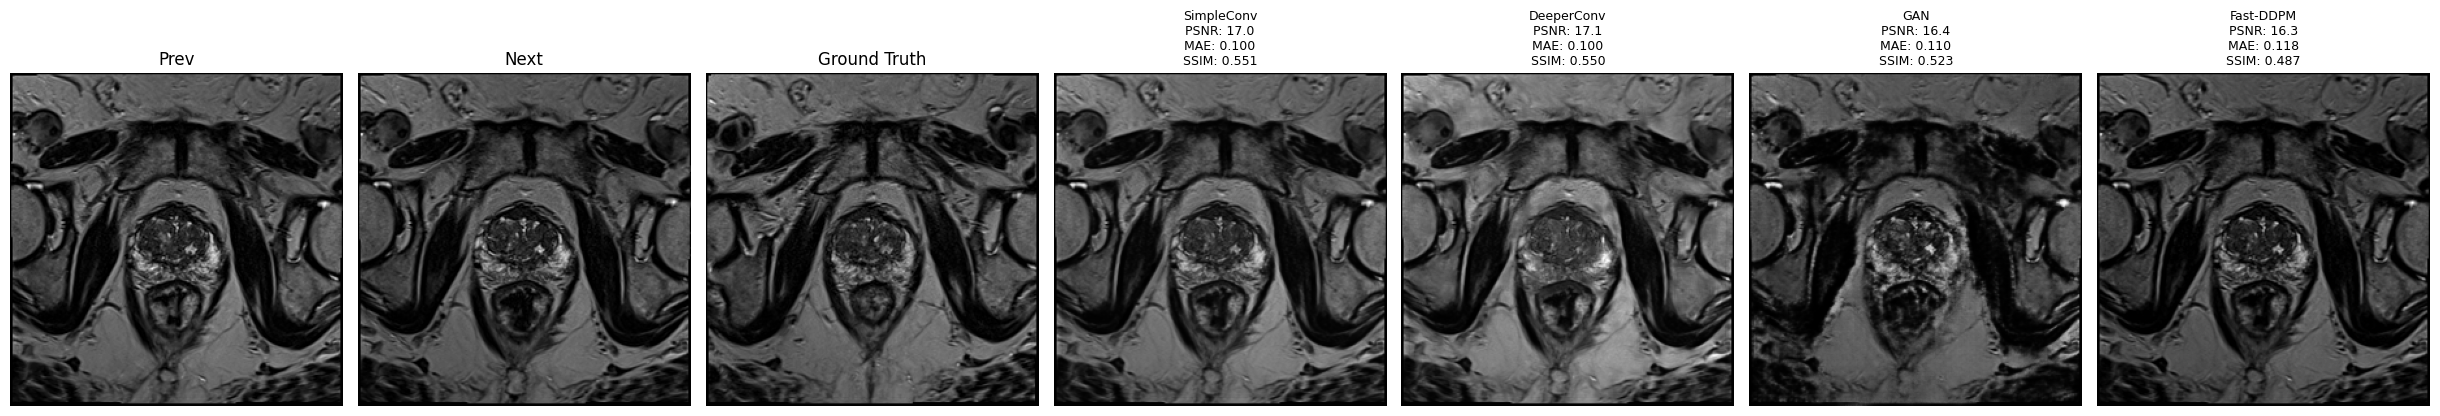

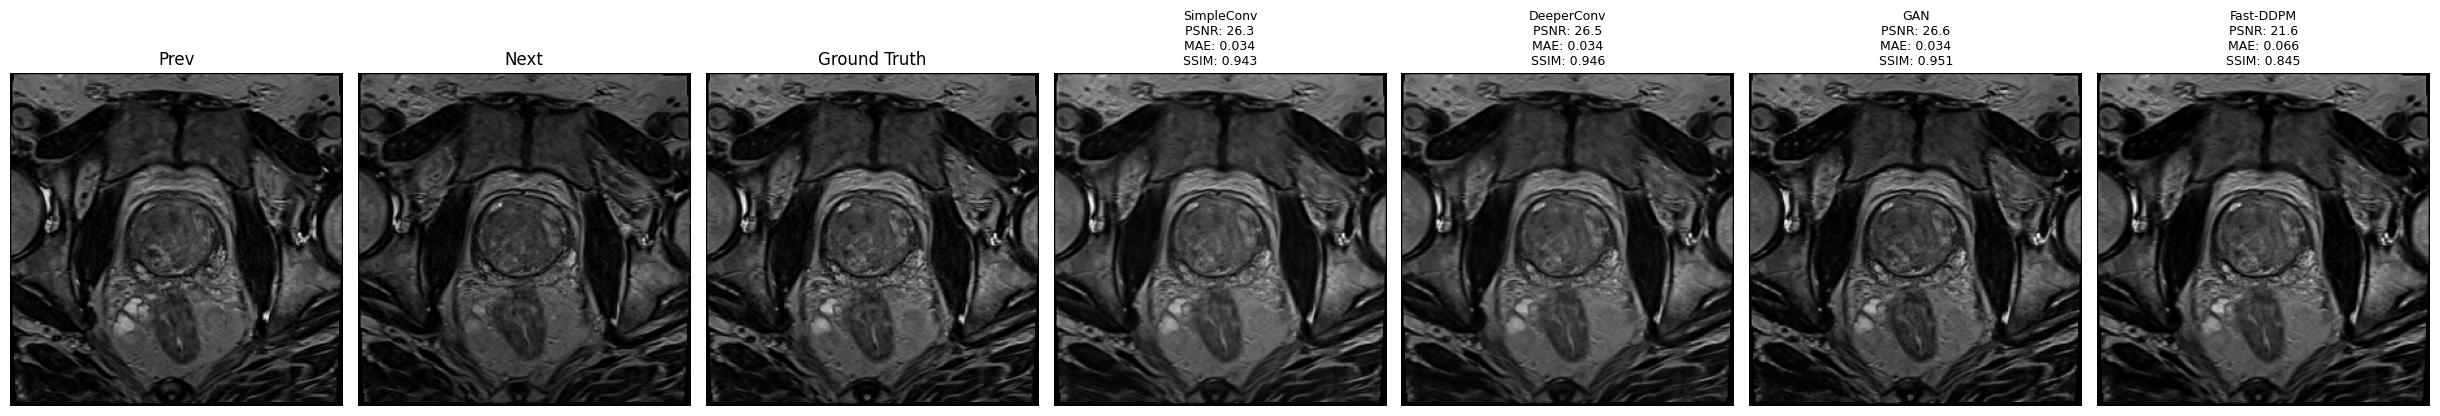

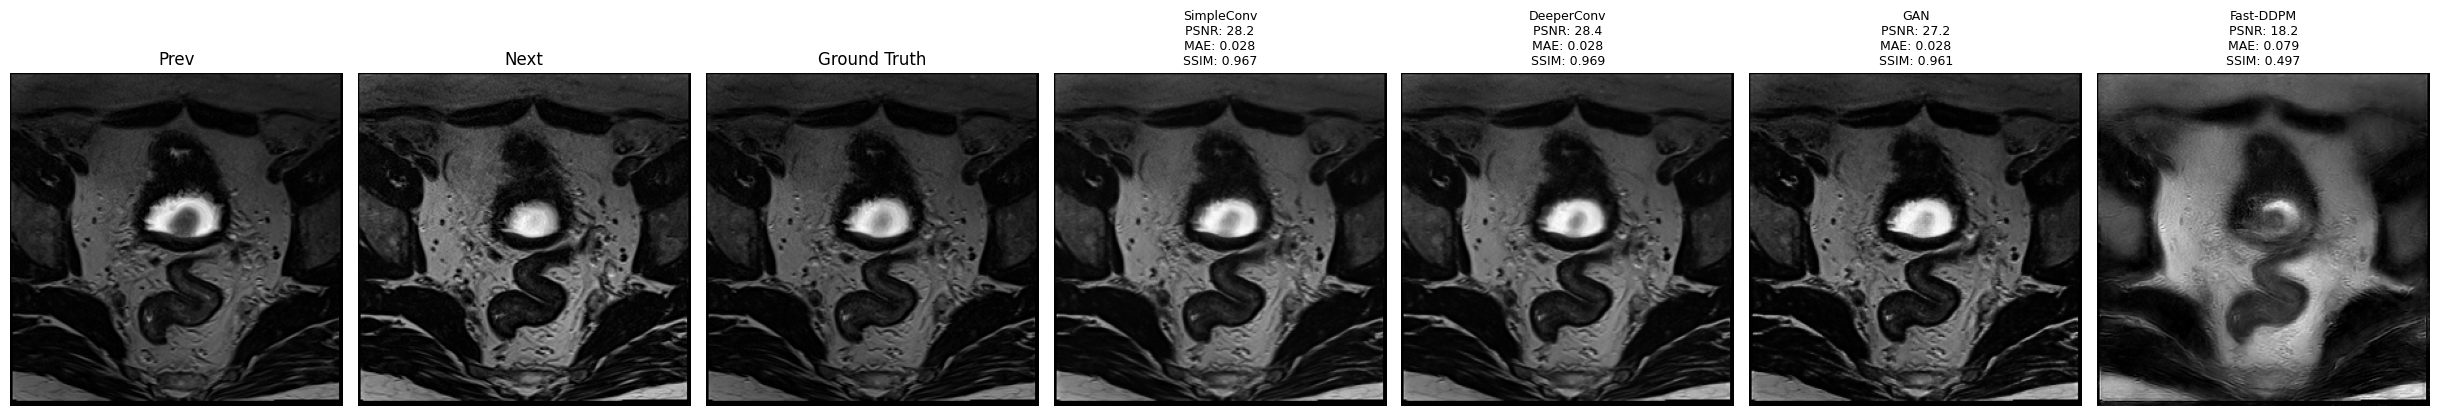

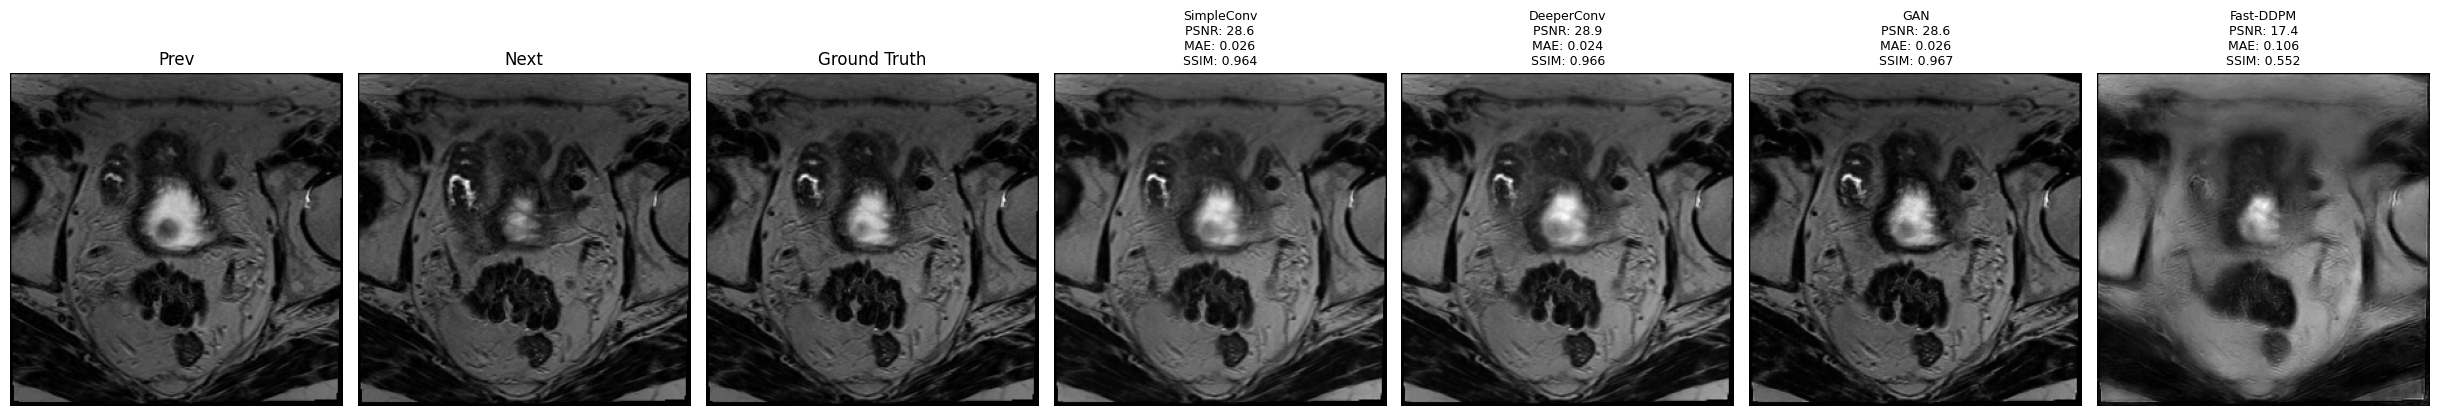

Running Stats (100 samples)...


  0%|          | 0/8592 [00:00<?, ?it/s]

/scratch/local/20249727/ipykernel_2075359/2760383443.py:366: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(stats_psnr.keys()); axes[0].set_title("PSNR (Higher is better)"); axes[0].set_ylabel("dB")
/scratch/local/20249727/ipykernel_2075359/2760383443.py:369: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(stats_mae.keys()); axes[1].set_title("MAE (Lower is better)"); axes[1].set_ylabel("L1 Error")
/scratch/local/20249727/ipykernel_2075359/2760383443.py:372: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(stats_ssim.keys()); axes[2].set_title("SSIM (Higher is better)"); axes[2].set_ylabel("Index")


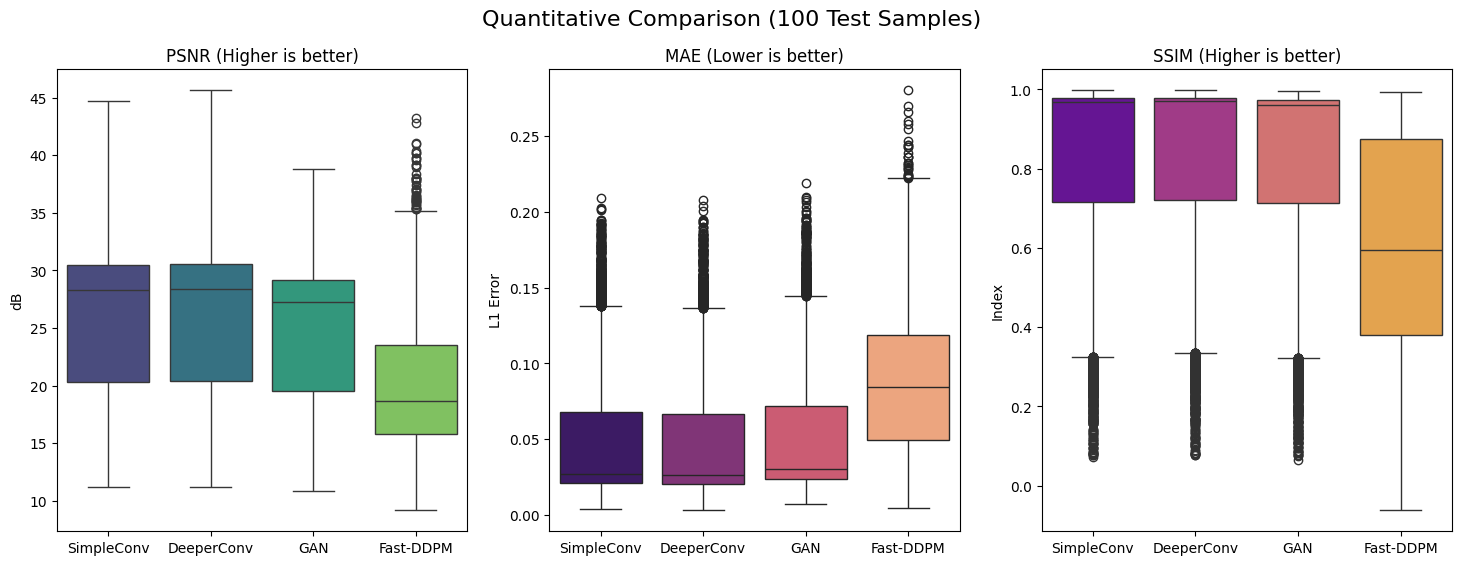

In [7]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm

# ============================================================
# 1. SETUP & CONFIGURATION
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DATA_PATH = Path("ProstateMRI_T2_MR_png/test/HR")

# Checkpoint Mapping: Display Name -> Filename
CHECKPOINTS = {
    "SimpleConv": "best_SimpleConvolutionalModel.pth",
    "DeeperConv": "best_DeeperConvolutionalModel.pth",
    "GAN": "best_SliceSynthesizer_G.pth",
    "Fast-DDPM": "mri_interp_weights.pth" 
}

print(f"Running Inference on: {DEVICE}")

# ============================================================
# 2. METRIC FUNCTIONS
# ============================================================

def calc_psnr(a, b):
    mse = F.mse_loss(a, b).item()
    return 20 * math.log10(1.0/math.sqrt(mse)) if mse > 0 else 100

def calc_mae(a, b):
    return F.l1_loss(a, b).item()

def calc_ssim(img1, img2):
    if img1.dim() == 4: img1 = img1.squeeze()
    if img2.dim() == 4: img2 = img2.squeeze()
    mu1, mu2 = img1.mean(), img2.mean()
    var1, var2 = img1.var(), img2.var()
    cov = ((img1 - mu1) * (img2 - mu2)).mean()
    c1, c2 = 0.0001, 0.0009
    return ((2 * mu1 * mu2 + c1) * (2 * cov + c2) / ((mu1**2 + mu2**2 + c1) * (var1 + var2 + c2))).item()

# ============================================================
# 3. MODEL ARCHITECTURES
# ============================================================

# --- 1. Simple Convolutional Model ---
class SimpleConvolutionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Conv2d(2, 64, 9, padding=4)
        self.non_linear_map = nn.Conv2d(64, 32, 5, padding=2)
        self.reconstruction = nn.Conv2d(32, 1, 5, padding=2)

    def forward(self, x):
        x = F.relu(self.feature_extractor(x))
        x = F.relu(self.non_linear_map(x))
        return torch.sigmoid(self.reconstruction(x))

# --- 2. Deeper Convolutional Model ---
class DeeperConvolutionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        layer_list = []
        input_channels = 2
        for output_channels in [64, 64, 64, 32]:
            layer_list.append(nn.Conv2d(input_channels, output_channels, 3, padding=1))
            layer_list.append(nn.ReLU(inplace=True))
            input_channels = output_channels
        layer_list.append(nn.Conv2d(input_channels, 1, 3, padding=1))
        self.network = nn.Sequential(*layer_list)

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# --- 3. Slice Synthesizer (GAN Generator) ---
class UNetConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels, is_downsample=True):
        super().__init__()
        if is_downsample:
            self.operation = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, 4, 2, 1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, True),
            )
        else:
            self.operation = nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, 4, 2, 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(True),
            )
    def forward(self, x): return self.operation(x)

class SliceSynthesizer(nn.Module):
    def __init__(self, base_filters=64):
        super().__init__()
        self.down_a = UNetConvBlock(2, base_filters, True)
        self.down_b = UNetConvBlock(base_filters, base_filters * 2, True)
        self.down_c = UNetConvBlock(base_filters * 2, base_filters * 4, True)
        self.deepest_point = nn.Sequential(
            nn.Conv2d(base_filters * 4, base_filters * 4, 3, 1, 1), 
            nn.ReLU(True)
        )
        self.up_c = UNetConvBlock(base_filters * 4, base_filters * 2, False)
        self.up_b = UNetConvBlock(base_filters * 4, base_filters, False)
        self.up_a = UNetConvBlock(base_filters * 2, base_filters, False)
        self.output_layer = nn.Conv2d(base_filters, 1, 3, padding=1)

    def forward(self, x):
        d_a = self.down_a(x)
        d_b = self.down_b(d_a)
        d_c = self.down_c(d_b)
        b = self.deepest_point(d_c)
        u_c = self.up_c(b); u_c = torch.cat([u_c, d_b], dim=1)
        u_b = self.up_b(u_c); u_b = torch.cat([u_b, d_a], dim=1)
        u_a = self.up_a(u_b)
        return torch.sigmoid(self.output_layer(u_a))

# --- 4. Fast-DDPM (ConditionalResUNet) ---
def make_time_embed(steps, dim_out, dev):
    half_d = dim_out // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half_d, device=dev).float() / half_d)
    raw = steps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(raw), torch.cos(raw)], dim=-1)
    if dim_out % 2 == 1: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb

class TimeAwareResBlock(nn.Module):
    def __init__(self, ch_in, ch_out, t_dim):
        super().__init__()
        self.c1 = nn.Conv2d(ch_in, ch_out, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, ch_out)
        self.c2 = nn.Conv2d(ch_out, ch_out, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, ch_out)
        self.t_proj = nn.Linear(t_dim, ch_out)
        self.activ = nn.SiLU()
        self.bypass = nn.Conv2d(ch_in, ch_out, 1) if ch_in != ch_out else nn.Identity()
    def forward(self, x, t_vec):
        h = self.activ(self.gn1(self.c1(x)))
        h = h + self.t_proj(t_vec)[:, :, None, None]
        h = self.activ(self.gn2(self.c2(h)))
        return h + self.bypass(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, t_dim, shrink=True):
        super().__init__()
        self.b1 = TimeAwareResBlock(in_c, out_c, t_dim)
        self.b2 = TimeAwareResBlock(out_c, out_c, t_dim)
        self.sampler = nn.Conv2d(out_c, out_c, 4, 2, 1) if shrink else nn.Identity()
    def forward(self, x, t):
        x = self.b1(x, t); x = self.b2(x, t)
        return self.sampler(x), x

class DecoderBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c, t_dim, grow=True):
        super().__init__()
        self.sampler = nn.ConvTranspose2d(in_c, out_c, 4, 2, 1) if grow else nn.Identity()
        self.b1 = TimeAwareResBlock(out_c + skip_c, out_c, t_dim)
        self.b2 = TimeAwareResBlock(out_c, out_c, t_dim)
    def forward(self, x, skip, t):
        x = self.sampler(x); x = torch.cat([x, skip], dim=1)
        x = self.b1(x, t); x = self.b2(x, t)
        return x

class ConditionalResUNet(nn.Module):
    def __init__(self, t_dim=256, dim=64):
        super().__init__()
        self.t_dim = t_dim
        self.time_net = nn.Sequential(nn.Linear(t_dim, t_dim), nn.SiLU(), nn.Linear(t_dim, t_dim))
        self.e1 = EncoderBlock(3, dim, t_dim)
        self.e2 = EncoderBlock(dim, dim * 2, t_dim)
        self.e3 = EncoderBlock(dim * 2, dim * 4, t_dim)
        self.mid1 = TimeAwareResBlock(dim * 4, dim * 4, t_dim)
        self.mid2 = TimeAwareResBlock(dim * 4, dim * 4, t_dim)
        self.d3 = DecoderBlock(dim * 4, dim * 4, dim * 2, t_dim)
        self.d2 = DecoderBlock(dim * 2, dim * 2, dim, t_dim)
        self.final_up = nn.ConvTranspose2d(dim, dim, 4, 2, 1)
        self.head = nn.Sequential(nn.Conv2d(dim, dim, 3, padding=1), nn.SiLU(), nn.Conv2d(dim, 1, 3, padding=1))

    def forward(self, noisy_img, context_imgs, t_step):
        emb = self.time_net(make_time_embed(t_step, self.t_dim, noisy_img.device))
        combined = torch.cat([noisy_img, context_imgs], dim=1)
        x, s1 = self.e1(combined, emb); x, s2 = self.e2(x, emb); x, s3 = self.e3(x, emb)
        x = self.mid2(self.mid1(x, emb), emb)
        x = self.d3(x, s3, emb); x = self.d2(x, s2, emb)
        return self.head(self.final_up(x))

class FastDDPMSampler:
    def __init__(self, device):
        self.device = device
        self.T_base, self.T_fast = 1000, 10
        boundary = 699
        n_high = int(self.T_fast * 0.6); n_low = self.T_fast - n_high
        low = torch.linspace(0, boundary, n_low, device=device)
        high = torch.linspace(boundary, self.T_base - 1, n_high, device=device)
        self.fast_indices = torch.cat([low, high]).round().long().sort()[0]
        betas = torch.linspace(1e-4, 2e-2, self.T_base, device=device)
        alphas_cumprod = torch.cumprod(1.0 - betas, dim=0)
        self.alphas_cumprod_fast = alphas_cumprod[self.fast_indices]
        self.alphas_fast = torch.empty_like(self.alphas_cumprod_fast)
        self.alphas_fast[0] = self.alphas_cumprod_fast[0]
        self.alphas_fast[1:] = self.alphas_cumprod_fast[1:] / self.alphas_cumprod_fast[:-1]
        self.betas_fast = 1.0 - self.alphas_fast
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas_fast)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod_fast)
        self.posterior_variance = self.betas_fast * (1.0 - torch.cat([torch.tensor([1.0], device=device), self.alphas_cumprod_fast[:-1]])) / (1.0 - self.alphas_cumprod_fast)

    def sample(self, model, ctx):
        model.eval()
        b, _, h, w = ctx.shape
        x = torch.randn(b, 1, h, w, device=self.device)
        for i in reversed(range(self.T_fast)):
            t = torch.full((b,), i, device=self.device, dtype=torch.long)
            with torch.no_grad(): eps = model(x, ctx, t)
            mean = self.sqrt_recip_alphas[i] * (x - self.betas_fast[i] / self.sqrt_one_minus_alphas_cumprod[i] * eps)
            noise = torch.randn_like(x) if i > 0 else 0
            x = mean + torch.sqrt(self.posterior_variance[i]) * noise
        return x.clamp(0, 1)

# ============================================================
# 4. ROBUST DATA LOADING
# ============================================================
def get_test_triplets(root_dir):
    if not root_dir.exists():
        print(f"ERROR: Path {root_dir} does not exist.")
        return []
        
    files = sorted(list(root_dir.glob("*.png")))
    patient_files = {}
    for f in files:
        parts = f.stem.split('_z')
        if len(parts) != 2: continue
        pid, idx = parts[0], int(parts[1])
        if pid not in patient_files: patient_files[pid] = []
        patient_files[pid].append((idx, f))
    
    triplets = []
    for pid, slices in patient_files.items():
        slices.sort(key=lambda x: x[0])
        for i in range(1, len(slices)-1):
            if slices[i][0] == slices[i-1][0] + 1 and slices[i+1][0] == slices[i][0] + 1:
                triplets.append((slices[i-1][1], slices[i][1], slices[i+1][1]))
    return triplets

def load_image(path):
    try:
        img = Image.open(path).convert("F").resize((256, 256))
        return torch.from_numpy(np.array(img)/255.0).unsqueeze(0).unsqueeze(0).float()
    except (OSError, UnidentifiedImageError):
        print(f"Skipping corrupt image: {path.name}")
        return None

# ============================================================
# 5. EXECUTION & RESULTS
# ============================================================
sampler = FastDDPMSampler(DEVICE)
models = {}

def load_ckpt(model, path):
    try:
        state = torch.load(path, map_location=DEVICE)
        # Handle DataParallel Wrapping from training
        if list(state.keys())[0].startswith('module.'):
            state = {k[7:]: v for k, v in state.items()}
        model.load_state_dict(state)
        return model.eval().to(DEVICE)
    except Exception as e:
        print(f"FAILED {path}: {e}")
        return None

# Load models using new class names
if os.path.exists(CHECKPOINTS["SimpleConv"]): 
    models["SimpleConv"] = load_ckpt(SimpleConvolutionalModel(), CHECKPOINTS["SimpleConv"])

if os.path.exists(CHECKPOINTS["DeeperConv"]): 
    models["DeeperConv"] = load_ckpt(DeeperConvolutionalModel(), CHECKPOINTS["DeeperConv"])

if os.path.exists(CHECKPOINTS["GAN"]): 
    models["GAN"] = load_ckpt(SliceSynthesizer(), CHECKPOINTS["GAN"])

if os.path.exists(CHECKPOINTS["Fast-DDPM"]): 
    models["Fast-DDPM"] = load_ckpt(ConditionalResUNet(), CHECKPOINTS["Fast-DDPM"])

print(f"Models Loaded: {list(models.keys())}")

# --- 1. Qualitative (5 Examples) ---
print(">>> Generating 5 Examples...")
triplets = get_test_triplets(TEST_DATA_PATH)
if len(triplets) > 0:
    step = max(1, len(triplets) // 5)
    indices = [i * step for i in range(5)]

    for count, idx in enumerate(indices):
        if idx >= len(triplets): break
        
        p_path, m_path, n_path = triplets[idx]
        prev = load_image(p_path)
        nxt  = load_image(n_path)
        gt   = load_image(m_path)
        
        if prev is None or nxt is None or gt is None: continue
            
        prev, nxt, gt = prev.to(DEVICE), nxt.to(DEVICE), gt.to(DEVICE)
        ctx = torch.cat([prev, nxt], 1)
        
        outputs = {}
        with torch.no_grad():
            for name, model in models.items():
                if name == "Fast-DDPM": outputs[name] = sampler.sample(model, ctx)
                else: outputs[name] = model(ctx).clamp(0, 1)

        n_cols = 3 + len(outputs)
        fig, axes = plt.subplots(1, n_cols, figsize=(3.5*n_cols, 4.5))
        axes[0].imshow(prev.cpu().squeeze(), cmap="gray"); axes[0].set_title("Prev")
        axes[1].imshow(nxt.cpu().squeeze(), cmap="gray"); axes[1].set_title("Next")
        axes[2].imshow(gt.cpu().squeeze(), cmap="gray"); axes[2].set_title("Ground Truth")
        
        for i, (name, img) in enumerate(outputs.items()):
            p_val = calc_psnr(img, gt)
            m_val = calc_mae(img, gt)
            s_val = calc_ssim(img, gt)
            axes[3+i].imshow(img.cpu().squeeze(), cmap="gray")
            axes[3+i].set_title(f"{name}\nPSNR: {p_val:.1f}\nMAE: {m_val:.3f}\nSSIM: {s_val:.3f}", fontsize=9)
            
        for ax in axes: ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"Final_Report_Qualitative_{count+1}.png", dpi=300)
        plt.show()

# --- 2. Quantitative (Boxplots) ---
print("Running Stats (100 samples)...")
stats_psnr = {k: [] for k in models.keys()}
stats_mae  = {k: [] for k in models.keys()}
stats_ssim = {k: [] for k in models.keys()}


for p, m, n in tqdm(triplets):
    prev = load_image(p)
    nxt  = load_image(n)
    gt   = load_image(m)
    
    if prev is None or nxt is None or gt is None: continue
    
    prev, nxt, gt = prev.to(DEVICE), nxt.to(DEVICE), gt.to(DEVICE)
    ctx = torch.cat([prev, nxt], 1)
    
    with torch.no_grad():
        for name, model in models.items():
            if name == "Fast-DDPM": pred = sampler.sample(model, ctx)
            else: pred = model(ctx).clamp(0, 1)
            
            stats_psnr[name].append(calc_psnr(pred, gt))
            stats_mae[name].append(calc_mae(pred, gt))
            stats_ssim[name].append(calc_ssim(pred, gt))

if len(list(stats_psnr.values())[0]) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.boxplot(data=list(stats_psnr.values()), ax=axes[0], palette="viridis")
    axes[0].set_xticklabels(stats_psnr.keys()); axes[0].set_title("PSNR (Higher is better)"); axes[0].set_ylabel("dB")

    sns.boxplot(data=list(stats_mae.values()), ax=axes[1], palette="magma")
    axes[1].set_xticklabels(stats_mae.keys()); axes[1].set_title("MAE (Lower is better)"); axes[1].set_ylabel("L1 Error")

    sns.boxplot(data=list(stats_ssim.values()), ax=axes[2], palette="plasma")
    axes[2].set_xticklabels(stats_ssim.keys()); axes[2].set_title("SSIM (Higher is better)"); axes[2].set_ylabel("Index")

    plt.suptitle("Quantitative Comparison (100 Test Samples)", fontsize=16)
    plt.savefig("Final_Report_All_Stats.png", dpi=300)
    plt.show()
else:
    print("No valid statistics collected. Check data paths.")

In [8]:
import pandas as pd
import numpy as np

# ============================================================
# 7. GENERATE FINAL RESULTS TABLE
# ============================================================

results_table = []

# Iterate through each model
for model_name in stats_psnr.keys():
    # Get the list of scores for this model
    psnr_scores = stats_psnr[model_name]
    mae_scores = stats_mae[model_name]
    ssim_scores = stats_ssim[model_name]
    
    # Skip if no data was collected
    if len(psnr_scores) == 0:
        continue

    # Calculate Mean and Standard Deviation
    row = {
        "Model": model_name,
        "PSNR (dB)": f"{np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f}",
        "MAE":       f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        "SSIM":      f"{np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}"
    }
    results_table.append(row)

# Create a Pandas DataFrame
df = pd.DataFrame(results_table)

# Display the table cleanly
print("\n" + "="*80)
print("FINAL QUANTITATIVE RESULTS (Mean ± Std Dev)")
print("="*80)
print(df.to_string(index=False))
print("="*80)

# Save to CSV for your report
df.to_csv("Final_Quantitative_Results.csv", index=False)
print("✅ Saved results table to 'Final_Quantitative_Results.csv'")


FINAL QUANTITATIVE RESULTS (Mean ± Std Dev)
     Model    PSNR (dB)             MAE            SSIM
SimpleConv 26.09 ± 6.23 0.0475 ± 0.0412 0.8391 ± 0.2353
DeeperConv 26.20 ± 6.23 0.0466 ± 0.0405 0.8412 ± 0.2336
       GAN 25.12 ± 5.75 0.0502 ± 0.0410 0.8311 ± 0.2377
 Fast-DDPM 19.89 ± 5.28 0.0874 ± 0.0451 0.6045 ± 0.2665
✅ Saved results table to 'Final_Quantitative_Results.csv'
